## 1. Data preparation

### 1.1. Basic preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import time 

In [3]:
df = pd.read_csv('Reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


The dataset does not have any null values.

In [4]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [5]:
# check sum of unique items per column
df.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295742
Text                      393579
dtype: int64

**Removing duplicates:** 

Here we check if there is any duplicate reviews and remove them if they exist.

In [6]:
print(df.shape)
df=df.drop_duplicates(subset=['UserId','ProfileName','Time','Summary'],keep='first')
print(df.shape)

(568454, 10)
(392908, 10)


**Check if HelpfulnessNumerator is always larger than HelpfulnessDenominator:**

Two rows have incorrect data, which are removed. 

In [7]:
print(df.shape)
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]
print(df.shape)

(392908, 10)
(392906, 10)


**Adding "Sentiment" column:**

We rename the "HelpfulnessNumerator" and "HelpfulnessDenominator" columns as "VotesHelpful" and "VotesTotal", respectively, and add a "Sentiment" column where the sentiment is positive if score is more than 3 and negative if its score is less to 3. Neutral reviews with score equal to 3 are removed. From the value counts we can see that there is more positive reviews than negative reviews. 

In [8]:
# rename columns and add a sentiment column
df.columns = ['Id', 'ProductId', 'UserId', 'ProfileName', 'VotesHelpful',
       'VotesTotal', 'Score', 'Time', 'Summary', 'Text']

In [9]:
print(df.shape)
df = df[df['Score'] != 3]
print(df.shape)
df['Sentiment'] = df['Score'].apply(lambda score: 'positive' if score >3 else 'negative')
df['Sentiment'].value_counts()

(392906, 10)
(363200, 10)


positive    306184
negative     57016
Name: Sentiment, dtype: int64

In [10]:
df=df[['Score','Sentiment','Summary','Text']]
df.head()

,Score,Sentiment,Summary,Text
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,positive,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,negative,Cough Medicine,If you are looking for the secret ingredient i...
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...


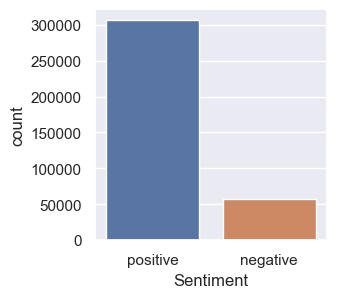

In [16]:
import seaborn as sns
sns.set_theme()
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(ax=ax,x=df['Sentiment'])
plt.show()

From the histogram, we can see that the data is imbalanced. 

### 1.2. Text preprocessing
1. **Decontracting phrases**: converting phrases like "I'm", "I'wont" to their decontracted versions 
2. **Removing html tags**
3. **Removing punctuations**
4. **Removing stopwords**: stopwords like "the", "a", "me" will be removed
5. **Stemming**: words will be transformed to its stem, e.g., tasty - tasti


In [17]:
import re
from bs4 import BeautifulSoup
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [18]:
df['Text'].head()

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

In [20]:
df['Text'][10]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

**An example of using `nltk`, `re`, and `bs4` for removing stopwords, punctuations, html tags, converting words to their stems:**

We first replace the contracted phasese like "I'm, won't" with their decontracted versions using the `re` package.

In [21]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [48]:
text = df['Text'][10]
print('Before:\n')
print(text)
decontracted_text = decontracted(text)
print()
print('After:\n')
print(decontracted_text)


Before:

I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!

After:

I do not know if it is the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on

Next, we use the `bs4` package to remove the html tags in the text, and use `re` to remove all punctuations.

In [49]:
print('Before:\n')
print(decontracted_text)
decontracted_text = BeautifulSoup(decontracted_text, 'lxml').get_text()
print()
print('After:\n')
print(decontracted_text)

Before:

I do not know if it is the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply could not find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but do not want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!

After:

I do not know if it is the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we wer

In [50]:
print('Before:\n')
print(decontracted_text)
decontracted_text = re.sub(r"[^a-zA-Z ]",r"",decontracted_text)
print()
print('After:\n')
print(decontracted_text)

Before:

I do not know if it is the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply could not find it anywhere in our city we were bummed.Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.If you love hot sauce..I mean really love hot sauce, but do not want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.Thank you for the personal, incredible service!

After:

I do not know if it is the cactus or the tequila or just the unique combination of ingredients but the flavour of this hot sauce makes it one of a kind  We picked up a bottle once on a trip we were on and brought it back home with us 

Now we use the method word_tokenize() to split a sentence into words. The output of word tokenization can be converted to Data Frame for better text understanding in machine learning applications. Then, we remove all the stopwords from the word tokens. 

In [44]:
# import stop words
stop_words = set(stopwords.words('english'))
print(stop_words)

{'but', 'did', "haven't", 'such', 'won', 'there', 'be', 'was', "mightn't", 'further', 'because', 'them', 'whom', 'hadn', 'you', 'from', 'doing', 'isn', 'over', 'll', 'while', 'once', 'having', 'until', 'own', 'ma', 'i', 'for', 'her', 'and', 'before', 'had', 'this', 'do', 'at', "couldn't", 'shouldn', 'to', 'that', 'ain', 'each', 'needn', 'off', 'where', 'ourselves', 'wouldn', 'how', 'yourself', 'ours', 'yourselves', 'why', 'nor', 'it', 'his', 'herself', "don't", 'no', 'couldn', "won't", 'an', 'other', "you'd", 'not', "shouldn't", 'shan', 'down', 'both', "you'll", 'their', 'so', 'been', 'about', 'can', 'is', "hasn't", 'they', 're', 'all', 'yours', 'after', 'd', 'wasn', 'by', 'have', 'up', 'if', "doesn't", 'him', 'above', 'me', "hadn't", 'now', 'we', 'hers', 'has', "should've", 'mustn', 'are', 'these', 'don', "mustn't", 'too', 'm', "aren't", 'most', 'the', 'than', 'more', 't', 'will', 'any', "you've", 'does', 'which', 'on', 'some', 'weren', 'those', "isn't", 'its', 'very', 'or', 'o', 'you

In [45]:
word_tokens = word_tokenize(decontracted_text.lower())
word_tokens_wo_stopwords = [w for w in word_tokens if w not in stop_words ]
print(word_tokens)
print()
print(word_tokens_wo_stopwords)
# print()
# print(" ".join(word_tokens_wo_stopwords))

['i', 'do', 'not', 'know', 'if', 'it', 'is', 'the', 'cactus', 'or', 'the', 'tequila', 'or', 'just', 'the', 'unique', 'combination', 'of', 'ingredients', 'but', 'the', 'flavour', 'of', 'this', 'hot', 'sauce', 'makes', 'it', 'one', 'of', 'a', 'kind', 'we', 'picked', 'up', 'a', 'bottle', 'once', 'on', 'a', 'trip', 'we', 'were', 'on', 'and', 'brought', 'it', 'back', 'home', 'with', 'us', 'and', 'were', 'totally', 'blown', 'away', 'when', 'we', 'realized', 'that', 'we', 'simply', 'could', 'not', 'find', 'it', 'anywhere', 'in', 'our', 'city', 'we', 'were', 'bummednow', 'because', 'of', 'the', 'magic', 'of', 'the', 'internet', 'we', 'have', 'a', 'case', 'of', 'the', 'sauce', 'and', 'are', 'ecstatic', 'because', 'of', 'itif', 'you', 'love', 'hot', 'saucei', 'mean', 'really', 'love', 'hot', 'sauce', 'but', 'do', 'not', 'want', 'a', 'sauce', 'that', 'tastelessly', 'burns', 'your', 'throat', 'grab', 'a', 'bottle', 'of', 'tequila', 'picante', 'gourmet', 'de', 'inclan', 'just', 'realize', 'that', '

Now we convert the works in `word_tokens_wo_stopwords` to their stems. 

In [46]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
word_tokens_stems = [ps.stem(w) for w in word_tokens_wo_stopwords]
print(word_tokens_stems)
print()
print(" ".join(word_tokens_stems))

['know', 'cactu', 'tequila', 'uniqu', 'combin', 'ingredi', 'flavour', 'hot', 'sauc', 'make', 'one', 'kind', 'pick', 'bottl', 'trip', 'brought', 'back', 'home', 'us', 'total', 'blown', 'away', 'realiz', 'simpli', 'could', 'find', 'anywher', 'citi', 'bummednow', 'magic', 'internet', 'case', 'sauc', 'ecstat', 'itif', 'love', 'hot', 'saucei', 'mean', 'realli', 'love', 'hot', 'sauc', 'want', 'sauc', 'tastelessli', 'burn', 'throat', 'grab', 'bottl', 'tequila', 'picant', 'gourmet', 'de', 'inclan', 'realiz', 'tast', 'never', 'want', 'use', 'saucethank', 'person', 'incred', 'servic']

know cactu tequila uniqu combin ingredi flavour hot sauc make one kind pick bottl trip brought back home us total blown away realiz simpli could find anywher citi bummednow magic internet case sauc ecstat itif love hot saucei mean realli love hot sauc want sauc tastelessli burn throat grab bottl tequila picant gourmet de inclan realiz tast never want use saucethank person incred servic


Let's now apply the same process to all the texts in the data: 

In [51]:
Cleaned_text = []
t = time.time()
for text in df['Text'].values:
    text = decontracted(text) #decontract words in text 
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub(r"[^a-zA-Z ]",r"",text)
    word_tokens = word_tokenize(text.lower())
    word_tokens_wo_stopwords = [w for w in word_tokens if w not in stop_words ]
    word_tokens_stems = [ps.stem(w) for w in word_tokens_wo_stopwords]
    Cleaned_text.append(" ".join(word_tokens_stems))


ElapsedTime = time.time()-t
print(f"{ElapsedTime} seconds has elapsed.")
    

395.70558881759644 seconds has elapsed.


In [52]:
df['Cleaned_text'] = Cleaned_text
df

,Score,Sentiment,Summary,Text,Cleaned_text
0,5,positive,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,1,negative,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanutsth peanu...
2,4,positive,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citru gel...
3,2,negative,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,positive,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...
...,...,...,...,...,...
568449,5,positive,Will not do without,Great for sesame chicken..this is a good if no...,great sesam chickenthi good better restur eate...
568450,2,negative,disappointed,I'm disappointed with the flavor. The chocolat...,disappoint flavor chocol note especi weak milk...
568451,5,positive,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",star small give one train session tri train do...
568452,5,positive,Favorite Training and reward treat,These are the BEST treats for training and rew...,best treat train reward dog good groom lower c...


In [53]:
df_clean = df[['Score','Cleaned_text']]
df_clean.loc[:,'Score'] = df_clean['Score'].apply(lambda score: 1 if score >3 else 0)

In [55]:
df_clean.head()

,Score,Cleaned_text
0,1,bought sever vital can dog food product found ...
1,0,product arriv label jumbo salt peanutsth peanu...
2,1,confect around centuri light pillowi citru gel...
3,0,look secret ingredi robitussin believ found go...
4,1,great taffi great price wide assort yummi taff...


In [56]:
# save dataframe as a csv file  
df_clean.to_csv('cleaned_data.csv',index=False)

## 2. Feature engineering

Creating features (vectors) from texts: 
1. Bag of words
    - Unigram
    - Bigram
2. TF-IDF (Term Frequency - Inverse Document Frequency )
3. Word2Vec

In [110]:
# read csv 
df_clean = pd.read_csv('cleaned_data.csv')

# We drop the rows with empty text. 
df_clean = df_clean.dropna()
df_clean.head()


,Score,Cleaned_text
0,1,bought sever vital can dog food product found ...
1,0,product arriv label jumbo salt peanutsth peanu...
2,1,confect around centuri light pillowi citru gel...
3,0,look secret ingredi robitussin believ found go...
4,1,great taffi great price wide assort yummi taff...


In [111]:
df_clean.isna().any()

Score           False
Cleaned_text    False
dtype: bool

**Sampling 100,000 entries from the whole dataset, and splitting the data into test and train sets:**

In [131]:
from sklearn.model_selection import train_test_split

df_clean = df_clean.sample(100000,random_state=0)

x = df_clean['Cleaned_text']
y = df_clean['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=1)


print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of y_train is {y_train.shape}')
print(f'The shape of y_test is {y_test.shape}')

The shape of X_train is (70000,)
The shape of X_test is (30000,)
The shape of y_train is (70000,)
The shape of y_test is (30000,)


### 2.1. Unigram

One word is taken as an input.

In [113]:
from sklearn.feature_extraction.text import CountVectorizer
t = time.time()
# BOW for unigram 
bow = CountVectorizer()
X_train_unigram = bow.fit_transform(X_train)
X_test_unigram = bow.transform(X_test)
unigram_features = bow.get_feature_names()

ElapsedTime = time.time()-t
print(f"{ElapsedTime} seconds has elapsed.")

2.7088656425476074 seconds has elapsed.


### 2.2. Bigram

Two words together are taken as one input.

In [135]:
t = time.time()
bigram = CountVectorizer(ngram_range=(1,2))
X_train_bigram = bigram.fit_transform(X_train)
X_test_bigram = bigram.transform(X_test)
bigram_features = bigram.get_feature_names()

ElapsedTime = time.time()-t
print(f"{ElapsedTime} seconds has elapsed.")

10.308050870895386 seconds has elapsed.


### 2.3. TFIDF: 

TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

In [132]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#applying bow on x_train and x_test
vectorizer = TfidfVectorizer()
# we use the fitted CountVectorizer to convert the text to vector

t = time.time()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
tfidf_features = vectorizer.get_feature_names()

ElapsedTime = time.time()-t
print(f"{ElapsedTime} seconds has elapsed.")

2.81314754486084 seconds has elapsed.


(70000, 78006)

### 2.4. Word2Vector embedding

In [115]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

t = time.time()
preprocessed_reviews = X_train.values
train_sentence = [rev.split() for rev in preprocessed_reviews]
# size = length of the w2v vectors 
# min_count = 5: we only consider words that occured 5 times minimum
w2v_model_train = Word2Vec(train_sentence,min_count=5,vector_size=50, workers=4)
w2v_words = list(w2v_model_train.wv.key_to_index)

ElapsedTime = time.time()-t
print(f"{ElapsedTime} seconds has elapsed.")

5.227527379989624 seconds has elapsed.


In [116]:
print("Number of words that occured minimum 5 times: ",len(w2v_words))
print("Sample words: ", w2v_words[0:50])

Number of words that occured minimum 5 times:  12674
Sample words:  ['like', 'tast', 'good', 'flavor', 'use', 'product', 'one', 'love', 'great', 'tri', 'would', 'tea', 'coffe', 'get', 'make', 'food', 'buy', 'time', 'eat', 'realli', 'order', 'much', 'price', 'amazon', 'find', 'also', 'littl', 'best', 'dog', 'bag', 'even', 'drink', 'store', 'well', 'go', 'chocol', 'better', 'box', 'mix', 'day', 'water', 'look', 'year', 'recommend', 'first', 'could', 'sugar', 'sweet', 'want', 'give']


## 2.5 Average Word2Vector 

We compute average word2vec for each review. 

In [117]:
from tqdm.auto import tqdm

# splitting each review into a list of words 
train_review_list=[]
for review in X_train.values:
    train_review_list.append(review.split())    
    
test_review_list=[]
for review in X_test.values:
    test_review_list.append(review.split())

In [119]:
train_sentence_vec = [] # the avg-w2v for each reveiw 
t = time.time()
for word_list in tqdm(train_review_list): # for each review (list of words generated from a review)
    sent_vec = np.zeros(50) #  
    word_count = 0 # number of words witha valid ector in the sentence/review 
    for word in word_list: 
        if word in w2v_words:
            vec = w2v_model_train.wv[word] # this returns the word vector for word 
            sent_vec += vec 
            word_count += 1
    if word_count != 0: 
        sent_vec /= word_count # averaging word vectors 
    train_sentence_vec.append(sent_vec)
ElapsedTime = time.time()-t
print(f"{ElapsedTime} seconds has elapsed.")


  0%|          | 0/70000 [00:00<?, ?it/s]

72.13664197921753 seconds has elapsed.


In [120]:
test_sentence_vec = [] # the avg-w2v for each reveiw 
t = time.time()
for word_list in tqdm(test_review_list): # for each review (list of words generated from a review)
    sent_vec = np.zeros(50) #  
    word_count = 0 # number of words witha valid ector in the sentence/review 
    for word in word_list: 
        if word in w2v_words:
            vec = w2v_model_train.wv[word] # this returns the word vector for word 
            sent_vec += vec 
            word_count += 1
    if word_count != 0: 
        sent_vec /= word_count # averaging word vectors 
    test_sentence_vec.append(sent_vec)
ElapsedTime = time.time()-t
print(f"{ElapsedTime} seconds has elapsed.")


  0%|          | 0/30000 [00:00<?, ?it/s]

31.185140371322632 seconds has elapsed.


In [121]:
print(len(train_sentence_vec))
print(len(test_sentence_vec))

70000
30000


In [122]:
X_train_avgw2v = np.array(train_sentence_vec)
X_test_avgw2v = np.array(test_sentence_vec)

**Saving test and train data**

In [123]:
np.save('savedData/X_train', X_train)
np.save('savedData/y_train', y_train)
np.save('savedData/X_test', X_test)
np.save('savedData/y_test', y_test)

In [124]:
import pickle 
pickle.dump(X_train_unigram, open('savedData/X_train_unigram',"wb"))
pickle.dump(X_test_unigram, open("savedData/X_test_unigram","wb"))
pickle.dump(np.array(unigram_features), open("savedData/unigram_features","wb"))

In [136]:
pickle.dump(X_train_bigram, open('savedData/X_train_bigram',"wb"))
pickle.dump(X_test_bigram, open("savedData/X_test_bigram","wb"))
pickle.dump(np.array(bigram_features), open("savedData/bigram_features","wb"))

In [134]:
pickle.dump(X_train_tfidf, open('savedData/X_train_tfidf',"wb"))
pickle.dump(X_test_tfidf, open("savedData/X_test_tfidf","wb"))
pickle.dump(np.array(tfidf_features), open("savedData/tfidf_features","wb"))

In [126]:
pickle.dump(np.array(w2v_words),open("savedData/w2v_words","wb"))
pickle.dump(np.array(X_train_avgw2v), open("savedData/X_train_avgw2v","wb"))
pickle.dump(np.array(X_test_avgw2v), open("savedData/X_test_avgw2v","wb"))